In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('BTC.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test với tỉ kệ 6:3:1
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 9s 266ms/step - loss: 0.0234 - val_loss: 0.0081
Epoch 2/100
16/16 [==============================] - 3s 171ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 3/100
16/16 [==============================] - 3s 177ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 4/100
16/16 [==============================] - 4s 261ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 5/100
16/16 [==============================] - 5s 286ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 6/100
16/16 [==============================] - 4s 277ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 7/100
16/16 [==============================] - 4s 225ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 8/100
16/16 [==============================] - 4s 223ms/step - loss: 0.0012 - val_loss: 0.0102
Epoch 9/100
16/16 [==============================] - 4s 225ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 10/100
16/16 [==============================] - 4s 258ms/step - loss: 0.0011 - val_lo

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 48ms/step


In [11]:
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print("Validation MAE:", valid_mae)
print("Testing MAE:", test_mae)

Validation RMSE: 0.062423357740844405
Testing RMSE: 0.2997987198429529
Validation MAPE: 14.260148104073084
Testing MAPE: 59.519035779399175
Validation MAE: 0.04913424302387267
Testing MAE: 0.24222494485017215


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

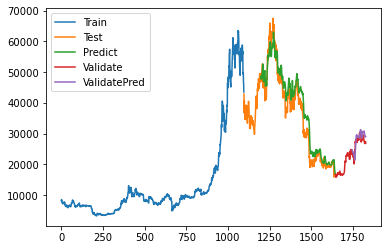

In [13]:
# 12.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()